# Decision Tree Model with One Hot Encoder for Categorical Variables

- Clean code version
- This version produced to produce a better tree diagram figure
- Also added state space search for meta parameter tuning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [5]:
data = loan_approval_lib.load_original_data()

In [6]:
data_train = loan_approval_lib.load_data_train()

In [7]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning

In [8]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [9]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [10]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [11]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [12]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [13]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [14]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [15]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [16]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Optimize Choice of Dataset

In [17]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [18]:
permutation = numpy.random.permutation(all_training_data.index)

In [22]:
n_samples = len(all_training_data)
n_samples

87274

In [23]:
k = 100

In [24]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [25]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [26]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

# Decision Tree Model

In [27]:
def decision_tree_model_train(
    data_train,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
):
    
    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=None,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
    )
    clf = clf.fit(X, Y)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)

    return (clf, feature_importances, accuracy_in_sample)

In [28]:
def decision_tree_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [29]:
def decision_tree_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [30]:
def decision_tree_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Decision Tree Model - Max Depth 2

- For publication

In [60]:
max_depth = 2
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    all_training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

# accuracy_out_of_sample = decision_tree_model_test(
#     clf,
#     all_training_data,
#     decision_tree_columns,
# )

# data_predict = decision_tree_model_predict(
#     clf,
#     data_test_copy,
#     decision_tree_columns,
#     decision_tree_columns_with_id,
# )

# decision_tree_model_predict_write_to_csv(
#     data_predict,
#     f'decision_tree_model_one_hot_encoder_2_clean_code-2-example_usage.csv'
# )

In [61]:
accuracy_in_sample

np.float64(0.9030753718174943)

In [62]:
# accuracy_out_of_sample

In [63]:
feature_importances

loan_grade_numerical          0.412054
loan_percent_income           0.406138
person_home_ownership_RENT    0.181808
dtype: float64

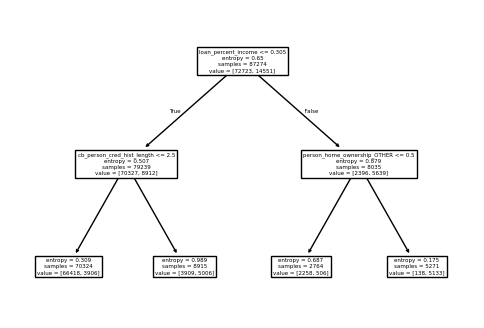

In [64]:
width = 6
height = 4
plt.figure(figsize=(width, height))

tree.plot_tree(clf, feature_names=all_training_data.columns, max_depth=2)

plt.savefig('decision_tree_model_one_hot_2_clean_code-2-maxdepth_2_tree.pdf')
plt.savefig('decision_tree_model_one_hot_2_clean_code-2-maxdepth_2_tree.png')
plt.show()

# Decision Tree Model - Max Depth

In [104]:
df = pandas.read_csv(filename, index_col=0)
df

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample,accuracy_out_of_sample
0,1.0,2,none,1,0.0,0.870407,0.872852
1,1.0,2,none,1,0.0,0.870534,0.860252
2,1.0,2,none,1,0.0,0.870580,0.855670
3,1.0,2,none,1,0.0,0.870441,0.869416
4,1.0,2,none,1,0.0,0.870499,0.863688
...,...,...,...,...,...,...,...
1895,none,2,none,1,0.0,0.999977,0.902523
1896,none,2,none,1,0.0,0.999977,0.925459
1897,none,2,none,1,0.0,0.999977,0.913991
1898,none,2,none,1,0.0,0.999977,0.917431


In [123]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    12, 14, 16, 18, 20,
    25, 30, 35, 40, 50, 60, 70, 80, 90, 100,
]
min_samples_split_list_input = [2, 3, 4, 5, 7, 10, 20]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_max_depth.csv'

df = None

for max_depth in max_depth_list_input:
    print(f'processing max_depth={max_depth}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)
        
        #data_predict = decision_tree_model_predict(
        #    clf,
        #    data_test_copy,
        #    decision_tree_columns,
        #    decision_tree_columns_with_id,
        #)
        
        #decision_tree_model_predict_write_to_csv(
        #    data_predict,
        #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_none.csv'
        #)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing max_depth=1
processing max_depth=2
processing max_depth=3
processing max_depth=4
processing max_depth=5
processing max_depth=6
processing max_depth=7
processing max_depth=8
processing max_depth=9
processing max_depth=10
processing max_depth=12
processing max_depth=14
processing max_depth=16
processing max_depth=18
processing max_depth=20
processing max_depth=25
processing max_depth=30
processing max_depth=35
processing max_depth=40
processing max_depth=50
processing max_depth=60
processing max_depth=70
processing max_depth=80
processing max_depth=90
processing max_depth=100
done


In [124]:
df = pandas.DataFrame(
    {
        'max_depth': max_depth_list,
        'min_samples_split': min_samples_split_list,
        'max_leaf_nodes': max_leaf_nodes_list,
        'min_samples_leaf': min_samples_leaf_list,
        'min_impurity_decrease': min_impurity_decrease_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        #'public_score': public_score_list,
        #'private_score': private_score_list,
    }
)

In [118]:
df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'

In [119]:
df.loc[df['max_depth'] == 'none', 'max_depth'] = 100 # number of features
df['max_depth'] = df['max_depth'].astype(float)
df['max_depth'] = df['max_depth'].astype(int)

In [125]:
df

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample,accuracy_out_of_sample
0,1,2,None,1,0.0,0.870407,0.872852
1,1,2,None,1,0.0,0.870534,0.860252
2,1,2,None,1,0.0,0.870580,0.855670
3,1,2,None,1,0.0,0.870441,0.869416
4,1,2,None,1,0.0,0.870499,0.863688
...,...,...,...,...,...,...,...
2495,100,2,None,1,0.0,0.999977,0.903670
2496,100,2,None,1,0.0,0.999977,0.920872
2497,100,2,None,1,0.0,0.999977,0.924312
2498,100,2,None,1,0.0,0.999977,0.917431


# Aggregate data for line graphs

In [88]:
aggregation_spec = {
    f'{input_column}': [
        (f'{input_column}_mean', 'mean'),
        (f'{input_column}_median', 'median'),
        (f'{input_column}_min', 'min'),
        (f'{input_column}_max', 'max'),
        (f'{input_column}_q1', lambda x: x.quantile(0.25)),
        (f'{input_column}_q3', lambda x: x.quantile(0.75)),
    ]
    for input_column in [
        'accuracy_in_sample',
        'accuracy_out_of_sample',
        #'oob_score',
        #'public_score',
        #'private_score',
    ]
}

In [90]:
df_aggregated = df.groupby(
    by=['max_depth', 'min_samples_split', 'max_leaf_nodes', 'min_samples_leaf', 'min_impurity_decrease']
).aggregate(
    aggregation_spec
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [94]:
df_aggregated.loc[df_aggregated['max_depth'] == 'none', 'max_depth'] = 19 # number of features
df_aggregated['max_depth'] = df_aggregated['max_depth'].astype(int)

In [95]:
df_aggregated

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample_mean,accuracy_in_sample_median,accuracy_in_sample_min,accuracy_in_sample_max,accuracy_in_sample_q1,accuracy_in_sample_q3,accuracy_out_of_sample_mean,accuracy_out_of_sample_median,accuracy_out_of_sample_min,accuracy_out_of_sample_max,accuracy_out_of_sample_q1,accuracy_out_of_sample_q3
0,1,2,none,1,0.0,0.870431,0.870430,0.870164,0.870673,0.870346,0.870522,0.870431,0.870487,0.846506,0.896907,0.861397,0.878866
1,2,2,none,1,0.0,0.903075,0.903068,0.902871,0.903440,0.903000,0.903141,0.903075,0.903780,0.866972,0.923253,0.896532,0.910576
2,3,2,none,1,0.0,0.912780,0.912779,0.912524,0.912987,0.912721,0.912848,0.912780,0.912944,0.892325,0.938144,0.906044,0.918671
3,4,2,none,1,0.0,0.927297,0.927305,0.927015,0.927548,0.927244,0.927362,0.927275,0.926690,0.903670,0.948454,0.921821,0.932417
4,5,2,none,1,0.0,0.940171,0.940203,0.939538,0.940418,0.940140,0.940255,0.940062,0.940435,0.919725,0.958763,0.935512,0.946163
5,6,2,none,1,0.0,0.943389,0.943398,0.943033,0.943647,0.943343,0.943450,0.943144,0.943807,0.920872,0.959908,0.936999,0.949556
6,7,2,none,1,0.0,0.944475,0.944399,0.944190,0.945197,0.944361,0.944471,0.943855,0.943807,0.924312,0.959908,0.939290,0.949556
7,8,2,none,1,0.0,0.946191,0.946199,0.945846,0.946483,0.946118,0.946262,0.944955,0.945017,0.925459,0.959908,0.940418,0.949599
8,9,2,none,1,0.0,0.947237,0.947211,0.946690,0.947987,0.947119,0.947316,0.944851,0.944986,0.925459,0.959908,0.940435,0.949599
9,10,2,none,1,0.0,0.948580,0.948565,0.948334,0.949052,0.948505,0.948638,0.944107,0.944413,0.922018,0.959908,0.939290,0.948726


# Plot in sample accuracy

In [276]:
filename = f'decision_tree_model_by_max_depth.csv'
df = pandas.read_csv(filename, index_col=0)

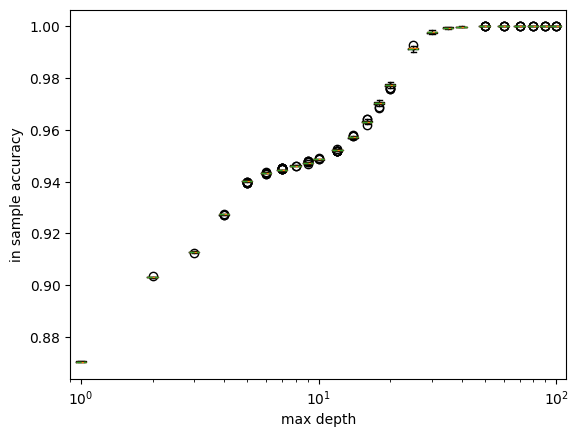

In [277]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_in_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9, xmax=110)
plt.xlabel('max depth')
plt.ylabel('in sample accuracy')

plt.savefig('decision_tree_model_by_max_depth-accuracy_in_sample.png')
plt.savefig('decision_tree_model_by_max_depth-accuracy_in_sample.pdf')

None

# Plot out of sample accuracy

[  1   2   3   4   5   6   7   8   9  10  12  14  16  18  20  25  30  35
  40  50  60  70  80  90 100]


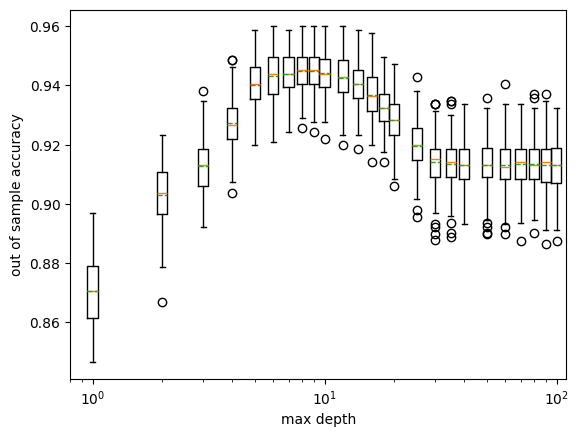

In [278]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):

    # if max_depth_ not in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                      10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                     100, 200]:
    #     pass #continue
    
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_out_of_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=110)
plt.xlabel('max depth')
plt.ylabel('out of sample accuracy')

plt.savefig('decision_tree_model_by_max_depth-accuracy_out_of_sample.png')
plt.savefig('decision_tree_model_by_max_depth-accuracy_out_of_sample.pdf')

print(numpy.array(positions))

None

In [270]:
# make prediction

max_depth = 100
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

# find best performing k
k_list = []
accuracy_in_sample_list = []
accuracy_out_of_sample_list = []

for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
        
    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )

    k_list.append(i)
    accuracy_in_sample_list.append(accuracy_in_sample)
    accuracy_out_of_sample_list.append(accuracy_out_of_sample)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_none.csv'
    #)

In [271]:
df = pandas.DataFrame(
    {
        'k': k_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
    }
)

In [272]:
df.sort_values(by=['accuracy_out_of_sample'])

,k,accuracy_in_sample,accuracy_out_of_sample
27,27,0.999977,0.890034
36,36,0.999977,0.894616
84,84,0.999977,0.895642
1,1,0.999977,0.895762
62,62,0.999977,0.896907
...,...,...,...
70,70,0.999977,0.928981
22,22,0.999977,0.930126
6,6,0.999977,0.932417
54,54,0.999988,0.933562


In [273]:
# predict using k = 43

max_depth = 100
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

k = 43
i = k

test_index = folds[i]
train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
    
training_data = all_training_data.loc[train_index]
test_data = all_training_data.loc[test_index]

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_100_k_43.csv'
)

In [ ]:
# result, above performs badly, 0.84

In [274]:
# now just train with everything
# predict using k = 43

max_depth = 100
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

training_data = all_training_data
test_data = all_training_data

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_100_all_training_data.csv'
)

In [ ]:
# also performs badly 0.84

# Decision Tree Model - Max Depth set to None, constrain Min Samples Split

In [149]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2, 3, 4, 5, 7, 10, 20]
min_samples_split_list_input = [15, 25, 30, 40, 50]
min_samples_split_list_input = [60, 70, 80, 90, 100]
min_samples_split_list_input = [150, 200, 300, 400, 500]
min_samples_split_list_input = [600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_min_samples_split.csv'

df = None

for min_samples_split in min_samples_split_list_input:
    print(f'processing min_samples_split={min_samples_split}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing min_samples_split=600
processing min_samples_split=700
processing min_samples_split=800
processing min_samples_split=900
processing min_samples_split=1000
processing min_samples_split=2000
processing min_samples_split=3000
processing min_samples_split=4000
processing min_samples_split=5000
done


In [170]:
filename = f'decision_tree_model_by_min_samples_split.csv'
df = pandas.read_csv(filename, index_col=0)

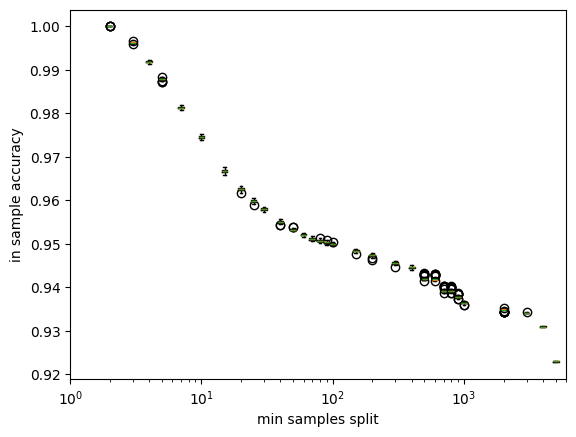

In [171]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_split_ in sorted(df_select['min_samples_split'].unique()):
    x.append(
        df[df['min_samples_split'] == min_samples_split_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_split_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=6000)
plt.xlabel('min samples split')
plt.ylabel('in sample accuracy')

None

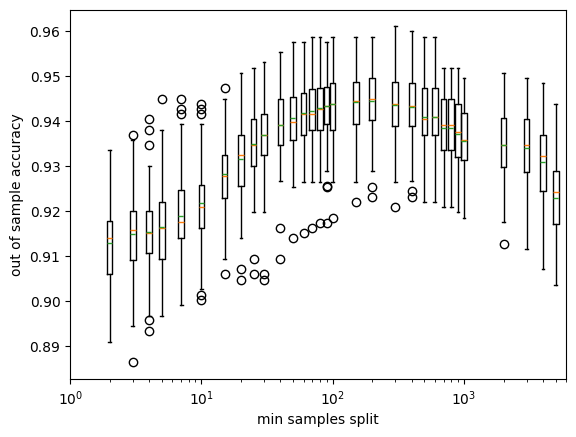

In [174]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_split_ in sorted(df_select['min_samples_split'].unique()):

    # if not min_samples_split_ in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                               10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                               100, 200, 300, 400, 500, 600, 700, 800, 900,
    #                               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
    #                               10000]:
    #     continue
    
    x.append(
        df[df['min_samples_split'] == min_samples_split_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_split_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=6000)
plt.xlabel('min samples split')
plt.ylabel('out of sample accuracy')

None

# Decision Tree Model - Max Depth set to None, constrain Max Leaf Nodes

In [181]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32]
max_leaf_nodes_list_input = [64, 128, 256, 512]
max_leaf_nodes_list_input = [1024, 1024 * 2, 1024 * 4, 1024 * 8]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_max_leaf_nodes.csv'

df = None

for max_leaf_nodes in max_leaf_nodes_list_input:
    print(f'processing max_leaf_nodes={max_leaf_nodes}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing max_leaf_nodes=1024
processing max_leaf_nodes=2048
processing max_leaf_nodes=4096
processing max_leaf_nodes=8192
done


In [197]:
filename = f'decision_tree_model_by_max_leaf_nodes.csv'
df = pandas.read_csv(filename, index_col=0)

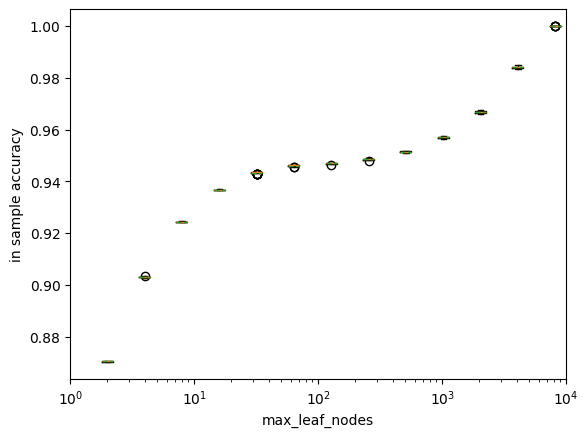

In [198]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_leaf_nodes_ in sorted(df_select['max_leaf_nodes'].unique()):
    x.append(
        df[df['max_leaf_nodes'] == max_leaf_nodes_]['accuracy_in_sample']
    )
    positions.append(
        max_leaf_nodes_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=10000)
plt.xlabel('max_leaf_nodes')
plt.ylabel('in sample accuracy')

None

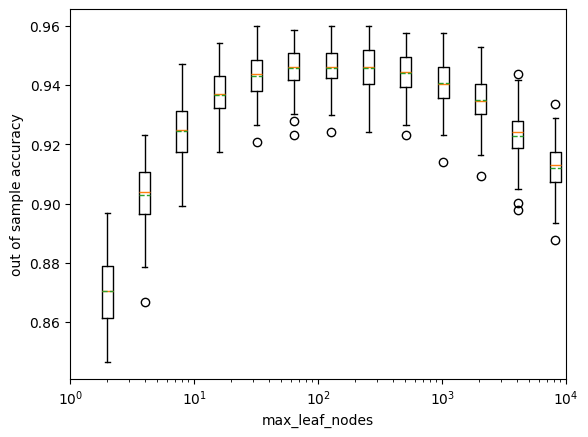

In [199]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_leaf_nodes_ in sorted(df_select['max_leaf_nodes'].unique()):
    x.append(
        df[df['max_leaf_nodes'] == max_leaf_nodes_]['accuracy_out_of_sample']
    )
    positions.append(
        max_leaf_nodes_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=10000)
plt.xlabel('max_leaf_nodes')
plt.ylabel('out of sample accuracy')

None

# Decision Tree Model - Max Depth set to None, constrain Min Samples Leaf

In [193]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [None]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
min_samples_leaf_list_input = [1024, 2048, 4096, 8192]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_min_samples_leaf.csv'

df = None

for min_samples_leaf in min_samples_leaf_list_input:
    print(f'processing min_samples_leaf={min_samples_leaf}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing min_samples_leaf=1024
processing min_samples_leaf=2048
processing min_samples_leaf=4096
processing min_samples_leaf=8192
done


In [201]:
filename = f'decision_tree_model_by_min_samples_leaf.csv'
df = pandas.read_csv(filename, index_col=0)

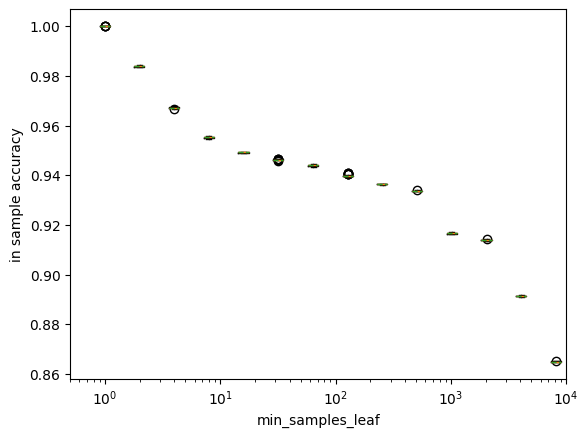

In [202]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df[df['min_samples_leaf'] == min_samples_leaf_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=10000)
plt.xlabel('min_samples_leaf')
plt.ylabel('in sample accuracy')

None

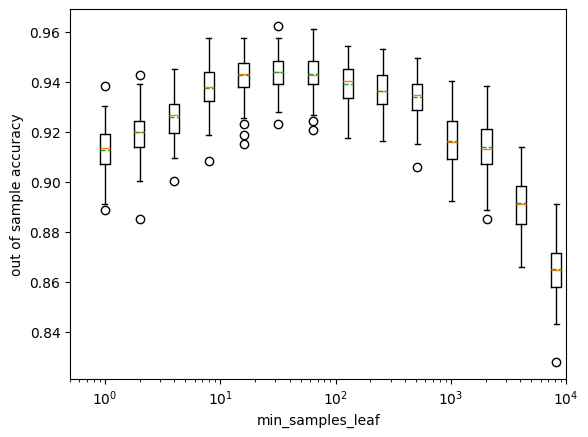

In [203]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df[df['min_samples_leaf'] == min_samples_leaf_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=10000)
plt.xlabel('min_samples_leaf')
plt.ylabel('out of sample accuracy')

None

# Decision Tree Model - Max Depth set to None, constrain Min Impurity Decrease

In [252]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [None]
min_samples_leaf_list_input = [1]
#min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]
#min_impurity_decrease_list_input = [1e-4, 1e-5, 1e-6]
#min_impurity_decrease_list_input = [5.0e-3, 5.0e-4, 5.0e-5, 5.0e-6]
#min_impurity_decrease_list_input = [2.0e-3, 2.0e-4, 2.0e-5, 2.0e-6]
min_impurity_decrease_list_input = [7.0e-5]
min_impurity_decrease_list_input = [3.0e-5, 4.0e-5]
min_impurity_decrease_list_input = [7.0e-3]
min_impurity_decrease_list_input = [8.0e-3, 9.0e-3]

filename = f'decision_tree_model_by_min_impurity_decrease.csv'

df = None

for min_impurity_decrease in min_impurity_decrease_list_input:
    print(f'processing min_impurity_decrease={min_impurity_decrease}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing min_impurity_decrease=0.008
processing min_impurity_decrease=0.009
done


In [253]:
filename = f'decision_tree_model_by_min_impurity_decrease.csv'
df = pandas.read_csv(filename, index_col=0)

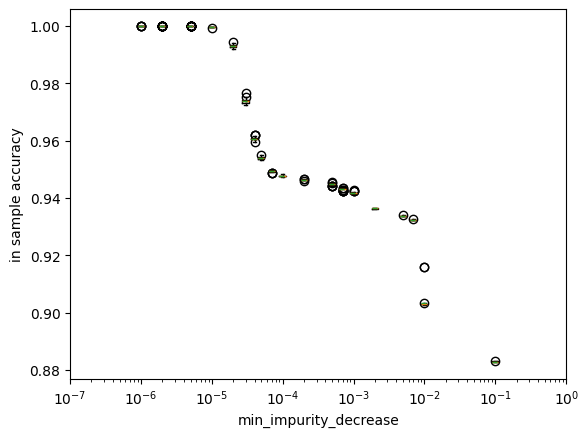

In [257]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_impurity_decrease_ in sorted(df_select['min_impurity_decrease'].unique()):

    if min_impurity_decrease_ in [8.0e-3, 9.0e-3]:
        continue
        
    x.append(
        df[df['min_impurity_decrease'] == min_impurity_decrease_]['accuracy_in_sample']
    )
    positions.append(
        min_impurity_decrease_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1e-7, xmax=1.0)
plt.xlabel('min_impurity_decrease')
plt.ylabel('in sample accuracy')

None

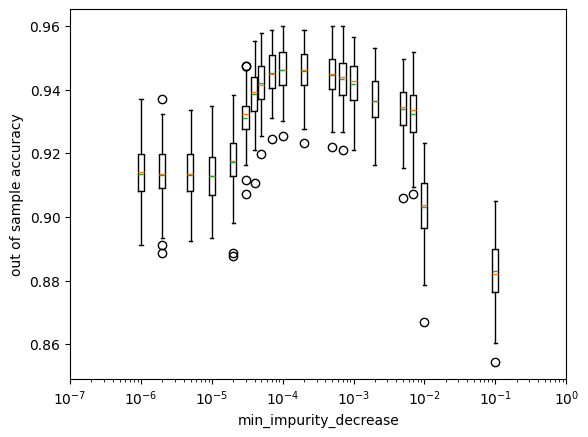

In [258]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_impurity_decrease_ in sorted(df_select['min_impurity_decrease'].unique()):

    if min_impurity_decrease_ in [8.0e-3, 9.0e-3]:
        continue
    
    x.append(
        df[df['min_impurity_decrease'] == min_impurity_decrease_]['accuracy_out_of_sample']
    )
    positions.append(
        min_impurity_decrease_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1e-7, xmax=1.0)
plt.xlabel('min_impurity_decrease')
plt.ylabel('out of sample accuracy')

# plt.scatter(
#     [7.0e-4, 7.0e-3],
#     [0.94, 0.92],
#     color='red',
#     sizes=[100, 100],
# )

# plt.plot(
#     [10e-5, 10e-5],
#     [0.85, 0.95],
#     color='red',
#     linewidth=2,
# )

None

# older code

In [87]:
df['accuracy_in_sample'].min(), df['accuracy_in_sample'].max()

(np.float64(0.8701635397738452), np.float64(0.9999884260598836))

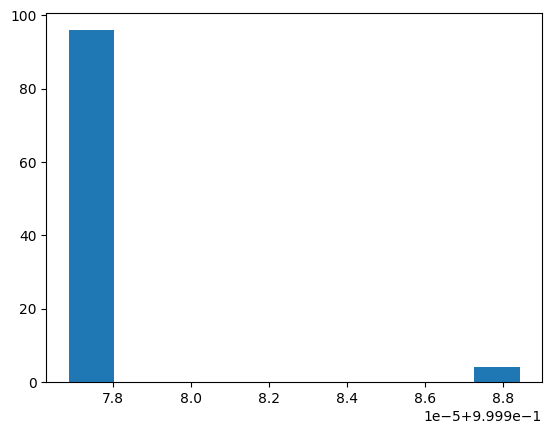

In [76]:
plt.figure()
plt.hist(df['accuracy_in_sample'])
None

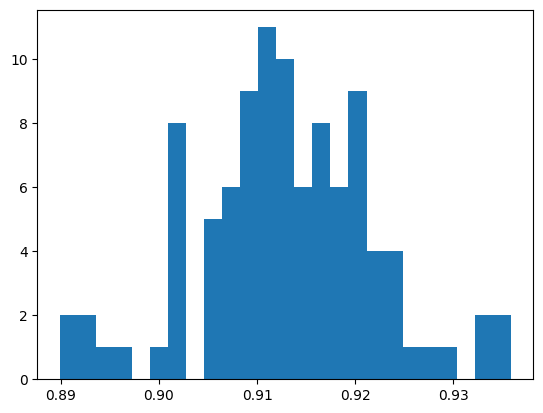

In [75]:
plt.figure()
plt.hist(df['accuracy_out_of_sample'], bins=25)
None

# Decision Tree Model - Max Depth 6

### Original dataset

- Use training portion of original dataset for training
- Use testing portion of original dataset for testing

In [98]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_copy_test, #data_train_copy,
    decision_tree_columns,
)

In [99]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [100]:
accuracy_out_of_sample

np.float64(0.9294582392776524)

In [101]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

### Original dataset for training, Kaggle competition dataset for testing

- Use training portion of original dataset for training
- Use Kaggle competition training dataset for testing

In [102]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy, #data_train_copy,
    decision_tree_columns,
)

In [103]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [104]:
accuracy_out_of_sample

np.float64(0.9494415551197886)

In [105]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

### Original dataset for training, Kaggle competition test dataset for submission creation

- Use training portion of original dataset for training
- Use Kaggle competition test dataset for prediction

In [108]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy_train, #data_copy,
    decision_tree_columns,
    6,
)

In [109]:
accuracy_in_sample

np.float64(0.9272777777777778)

In [110]:
feature_importances

loan_percent_income               0.289242
loan_grade_numerical              0.251810
person_home_ownership_RENT        0.206551
person_income                     0.102668
person_emp_length                 0.036395
person_home_ownership_OWN         0.029262
loan_intent_MEDICAL               0.028611
loan_intent_DEBTCONSOLIDATION     0.025695
loan_intent_HOMEIMPROVEMENT       0.012539
loan_int_rate                     0.009110
loan_intent_VENTURE               0.004524
person_home_ownership_MORTGAGE    0.002440
cb_person_cred_hist_length        0.001154
dtype: float64

In [107]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_6.csv'
)

### Repeat of above, but use full length dataset for training

- Use entire original dataset for training
- Use Kaggle competition test dataset for prediction

In [112]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    6,
)

In [114]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_6_full_training_dataset.csv'
)

# Decision Tree Model with more detailed regularization

In [132]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    None,
    30,
    4,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy,
    decision_tree_columns,
)

In [133]:
accuracy_in_sample

np.float64(0.9453059513830679)

In [134]:
accuracy_out_of_sample

np.float64(0.9427402165572513)

In [135]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_2_clean_code_maxdepth_None_minsamplesplit_30_minsamplenode_4_full_training_dataset.csv'
)

In [131]:
(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    data_copy,
    decision_tree_columns,
    None,
    2,
    10,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    data_train_copy,
    decision_tree_columns,
)

(accuracy_in_sample, accuracy_out_of_sample)

(np.float64(0.9429309863090248), np.float64(0.9386989513172479))